# 1. Setup

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow ddependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# 2. Collect Positives and Anchor

In [4]:
# https://vis-www.cs.umass.edu/lfw/

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\30c6b65e-4e4d-11ef-b865-84fdd1f05fd1.jpg'

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)  # hoặc thử các giá trị khác như 1, 2, 3 nếu 0 không hoạt động
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Không thể nhận khung hình từ webcam")
        break
    
    # Cut down frame to 250x250px
    frame = frame[90:90+250, 210:210+250]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('BOB', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


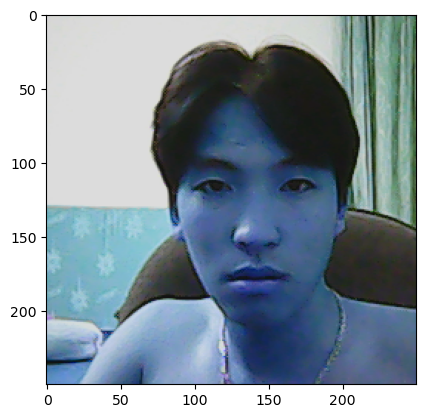

In [8]:
plt.imshow(frame)

# 3. Load and Preprocess Images

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [10]:
ANC_PATH+'\*.jpg'

'data\\anchor\\*.jpg'

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
dir_test.next()

b'data\\anchor\\30ceb41d-4d00-11ef-8fa6-84fdd1f05fd1.jpg'

In [13]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing staps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    # Return image
    return img

In [14]:
img = preprocess('data\\anchor\\6480556b-4d00-11ef-8b4a-84fdd1f05fd1.jpg')

In [15]:
img.numpy().max()

0.9343137

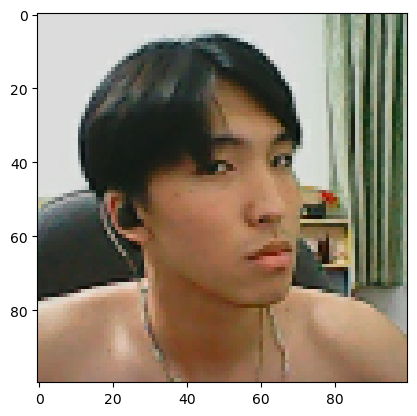

In [16]:
plt.imshow(img)

In [17]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
samples.next()

(b'data\\anchor\\68a56b03-4d00-11ef-a5f9-84fdd1f05fd1.jpg',
 b'data\\positive\\616950f7-4cff-11ef-b741-84fdd1f05fd1.jpg',
 1.0)

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
example = samples.next()

In [23]:
example

(b'data\\anchor\\683abf88-4d00-11ef-bfca-84fdd1f05fd1.jpg',
 b'data\\positive\\5de9a593-4cff-11ef-9b80-84fdd1f05fd1.jpg',
 1.0)

In [24]:
res = preprocess_twin(*example)

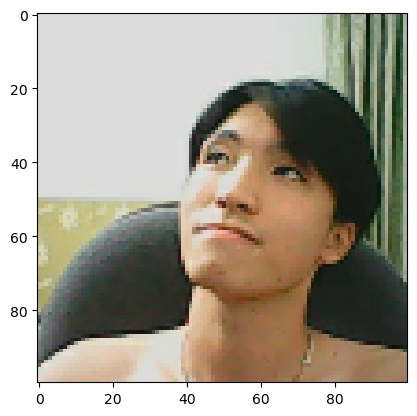

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering